# Newton-Raphson Iterative Method

This is a simple example to demonstrate how the Newton-Raphson method works for a simple non-linear equation.

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Problem Description

In this tutorial, we will apply the modified hyperbolic model (often used for the non-linear behaviour of soils):
$$ \tau(\gamma) = G_{sec}(\gamma) \gamma $$
where $\tau$ is the shear stress, $\gamma$ is the shear strain, and $G_{sec}(\gamma)$ is the secant shear modulus, given by:
$$ G_{sec}(\gamma) = \frac{G_{max}}{1+\left(\frac{\gamma}{\gamma_r}\right)^\alpha} $$
The model parameters are $G_{max}$ (representing the initial shear modulus), $\gamma_r$ (the shear strain at $G_{sec}/G_{max}=0.5$), and $\alpha$ (acting as a curvature parameter).

Note that the stress-strain equation above has a similar format to a typical FEA system, where:
$$ \{F\} = [K(U)] \{U\} $$

In [2]:
# Parameter Definition
G_max = 50000
gamma_r = 0.0005
alpha = 0.8

It is easy to obtain $\tau$ from $\gamma$, as shown below:

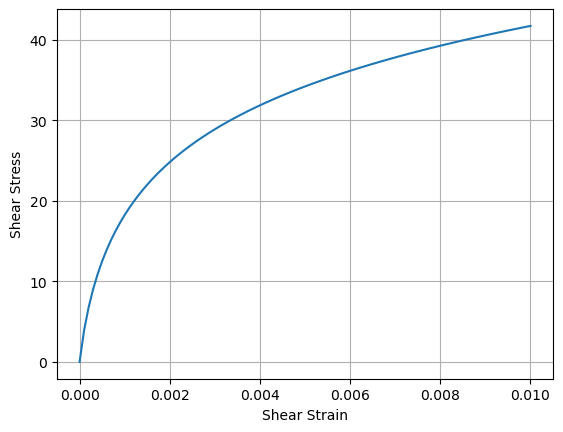

In [3]:
gamma = np.linspace(0,0.01,101)
G_sec = G_max / (1+(gamma/gamma_r)**alpha)
tau = G_sec*gamma

# Plot stress-strain graph:
plt.plot(gamma,tau)
plt.xlabel('Shear Strain')
plt.ylabel('Shear Stress')
plt.grid()
plt.show()

However, it is not possible to obtain $\gamma$ from $\tau$ analytically.

In the following section, this will be done numerically, using the Newton-Raphson method.

Let's assume that we need to calculate $\gamma$ for $\tau_o=40$.

In [4]:
tau_o = 40

## Basic Newton-Raphson

The equation to solve is:
$$ \tau(\gamma) = \tau_o $$

Applying a Taylor series expansion about $\gamma=\gamma_i$ and only keeping the first term:
$$\tau(\gamma_i) + \frac{d\tau(\gamma_i)}{d\gamma}(\gamma-\gamma_i) + ... = \tau_o $$

Using this formula iteratively:
$$ \gamma_{i+1} = \gamma_i + \frac{\tau_o-\tau_i}{G_{tan}(\gamma_i)} $$
where:
$$ \tau_i = \tau(\gamma_i) = G_{sec}(\gamma_i)\gamma_i $$
and $G_{tan}(\gamma)$ is the tangent shear modulus:
$$ G_{tan}(\gamma) = \frac{d\tau}{d\gamma} $$

For the modified hyperbolic model:
$$ G_{tan}(\gamma) = G_{max} \frac{ 1 + (1-\alpha) \left(\frac{\gamma}{\gamma_r}\right)^\alpha }
{ \left[ 1 + \left(\frac{\gamma}{\gamma_r}\right)^\alpha \right]^2 } $$

Number of performed iterations: 6


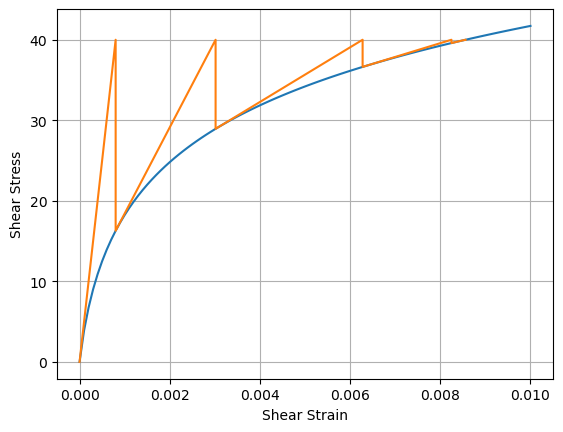

In [5]:
# Define arrays
gamma_i=np.array([0])
tau_i=np.array([0])

# Define error tolerance in terms of tau
tol_tau = 1e-3
# Define maximum iterations
max_iter = 100

# Newton-Raphson Loop
for i in range(max_iter):

    # Compute gamma_i[i+1] and append to gamma_i array
    G_tan = G_max * (1 + (1-alpha) * (gamma_i[-1]/gamma_r)**alpha) / (1 + (gamma_i[-1]/gamma_r)**alpha)**2
    gamma_i = np.append( gamma_i, gamma_i[-1] + (tau_o-tau_i[-1])/G_tan )
    tau_i = np.append( tau_i , tau_o ) # only for plotting purposes

    # Compute tau_i[i+1] to prepare for the next step and append to tau_i array
    G_sec = G_max / (1 + (gamma_i[-1]/gamma_r)**alpha )
    tau_i = np.append( tau_i, G_sec*gamma_i[-1] )
    gamma_i = np.append( gamma_i, gamma_i[-1] ) # only for plotting purposes

    # Error check
    if np.abs(tau_i[-1]-tau_o) < tol_tau:
        break

# Print Results
print('Number of performed iterations:',i+1)

# Plot Results
plt.plot(gamma,tau,gamma_i,tau_i)
plt.xlabel('Shear Strain')
plt.ylabel('Shear Stress')
plt.grid()
plt.show()

## Modified Newton-Raphson

This is similar to the basic Newton-Raphson, but $G_{max}$ is used instead of $G_{tan}$:
$$ \gamma_{i+1} = \gamma_i + \frac{\tau_o-\tau_i}{G_{max}} $$
This method is slower, but does not require any derivatives (or the Jacobian matrix, in matrix level).

In matrix level, the method also requires less matrix inversions.

Number of performed iterations: 337


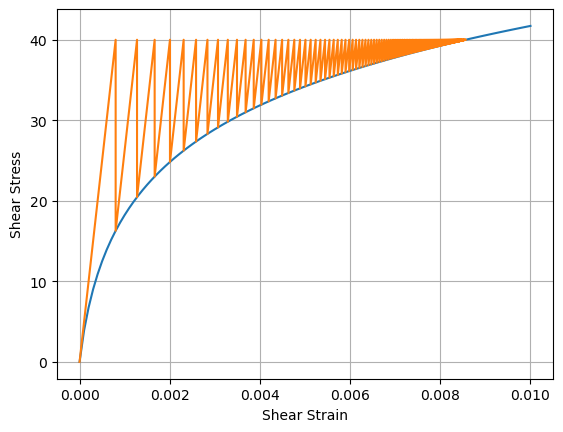

In [6]:
# Define arrays
gamma_i=np.array([0])
tau_i=np.array([0])

# Define error tolerance in terms of tau
tol_tau = 1e-3
# Define maximum iterations
max_iter = 1000 # the method did not converge with 100 iterations!

# Newton-Raphson Loop
for i in range(max_iter):

    # Compute gamma_i[i+1] and append to gamma_i array
    gamma_i = np.append( gamma_i, gamma_i[-1] + (tau_o-tau_i[-1])/G_max )
    tau_i = np.append( tau_i , tau_o ) # only for plotting purposes

    # Compute tau_i[i+1] to prepare for the next step and append to tau_i array
    G_sec = G_max / (1 + (gamma_i[-1]/gamma_r)**alpha )
    tau_i = np.append( tau_i, G_sec*gamma_i[-1] )
    gamma_i = np.append( gamma_i, gamma_i[-1] ) # only for plotting purposes

    # Error check
    if np.abs(tau_i[-1]-tau_o) < tol_tau:
        break

# Print Results
print('Number of performed iterations:',i+1)

# Plot Results
plt.plot(gamma,tau,gamma_i,tau_i)
plt.xlabel('Shear Strain')
plt.ylabel('Shear Stress')
plt.grid()
plt.show()

## Incremental Newton-Raphson

This is similar to the basic Newton-Raphson method, but performed incrementally, for a total of $n$ increments.

In each increment $j=1,2,...,n$, the target stress is set to:
$$ \tau_j = (j\Delta T) \tau_o $$
where a pseudo-time $T=[0,1]$ is defined and broken down to time-increments $\Delta T=1/n$.

This method is slower, but improves convergence in highly non-linear problems.

Total number of performed iterations: 16


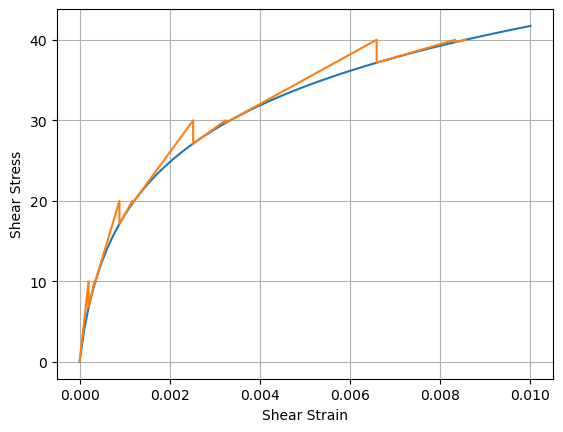

In [7]:
# Define arrays
gamma_i=np.array([0])
tau_i=np.array([0])

# Define error tolerance in terms of tau
tol_tau = 1e-3
# Define number of increments
incr = 4
tau_j = np.linspace(0,tau_o,incr+1)
# Define maximum iterations per increment
max_iter = 100
iter_tot = 0

# Increments
for j in range(incr):
# Everything remains the same, apart from tau_o becoming tau_o_i[j+1] (+1 needed because Python counts from zero)

    # Loop
    for i in range(max_iter):

        # Compute gamma_i[i+1] and append to gamma_i array
        G_tan = G_max * (1 + (1-alpha) * (gamma_i[-1]/gamma_r)**alpha) / (1 + (gamma_i[-1]/gamma_r)**alpha)**2
        gamma_i = np.append( gamma_i, gamma_i[-1] + (tau_j[j+1]-tau_i[-1])/G_tan )
        tau_i = np.append( tau_i , tau_j[j+1] ) # only for plotting purposes

        # Compute tau_i[i+1] to prepare for the next step and append to tau_i array
        G_sec = G_max / (1 + (gamma_i[-1]/gamma_r)**alpha )
        tau_i = np.append( tau_i, G_sec*gamma_i[-1] )
        gamma_i = np.append( gamma_i, gamma_i[-1] ) # only for plotting purposes

        # Error check
        if np.abs(tau_i[-1]-tau_j[j+1]) < tol_tau:
            break
    
    # Update number of iterations
    iter_tot += i+1

# Print Results
print('Total number of performed iterations:',iter_tot)

# Plot Results
plt.plot(gamma,tau,gamma_i,tau_i)
plt.xlabel('Shear Strain')
plt.ylabel('Shear Stress')
plt.grid()
plt.show()